In [1]:
import pandapower as pp 
import pandapower.plotting as plot
import numpy as np
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
import os
import pandapower.networks as nw
import random


In [2]:
net = nw.pp.create_empty_network() #create an empty net

In [3]:
# Loading the nodes, created in the NetworkX file: XNetwork_grid

# all nodes
nodes_orig = pd.read_csv('network_data/nodes_with_im.csv')
nodes_orig['NodeID'] = nodes_orig['NodeID'].astype(str) 

# subnetwork connection nodes
sub_con_nodes = pd.read_csv('network_data/sub_con_nodes.csv')
sub_con_nodes['NodeID'] = sub_con_nodes['NodeID'].astype(str) 

# subnetwork nodes
subnet_nodes = pd.read_csv('network_data/subnet_nodes.csv')
subnet_nodes['NodeID'] = subnet_nodes['NodeID'].astype(str) 

frames = [nodes_orig,sub_con_nodes,subnet_nodes] 
nodes_complet = pd.concat(frames)

# island grid with 2 is the mid grid
with open('network_data/grid_island.json') as json_data:
    grid_islands = json.load(json_data)

grid_mid = pd.DataFrame.from_dict(grid_islands['2'])
grid_mid = grid_mid.rename(columns = {0:'NodeID'}) 

grid_mid['r_voltage'] = 21.0
grid_low = nodes_complet[~nodes_complet['NodeID'].isin(grid_mid['NodeID'])]
grid_low['r_voltage'] = 0.42
grid_low = grid_low[['NodeID', 'r_voltage']]

frames = [grid_mid, grid_low]
grid_nodes = pd.concat(frames)

grid_nodes = pd.merge(grid_nodes, nodes_complet, on = 'NodeID', how='inner')


In [4]:
node_spotload = nodes_orig[nodes_orig['NodeID'].str.contains('SPOTLOAD')]

#node_spotload.to_csv(r'node_spotload.csv', header=True, index=None, mode='a')

In [5]:
# Nodes/busses

for i, row in grid_nodes.iterrows():
    pp.create_bus(net, name=row.NodeID, vn_kv=row.r_voltage, geodata = (row.CoordX,row.CoordY))

In [6]:
net.bus

,name,vn_kv,type,zone,in_service
0,42878164,21.00,b,None,True
1,42885537,21.00,b,None,True
2,42879302,21.00,b,None,True
3,42876385,21.00,b,None,True
4,42973730,21.00,b,None,True
5,52034635,21.00,b,None,True
6,42937598,21.00,b,None,True
7,52034695,21.00,b,None,True
8,42966814,21.00,b,None,True
9,42894297,21.00,b,None,True


In [7]:
# Loading the section csv for the lines

section = pd.read_csv('network_data/result_section_better.csv', header=0)

section = section[['SectionID', 'FromNodeID', 'ToNodeID']]
section['FromNodeID'] = section['FromNodeID'].astype(int)

#section

In [8]:
#cable = pd.read_csv('network_data/cable_combine.csv', header=0)

cable = pd.read_csv('network_data/cable.csv')
ug_cable = pd.read_csv('network_data/ug_cable_network.csv', header=0)

ug_cable = ug_cable.rename(index=str, columns={"LineCableID":"ID"})

ug_cable = ug_cable[["ID","SectionID", "Length"]].copy()
cable= cable.merge(ug_cable, on='ID')

#cable

In [9]:
# Transformer input, connecting with the node voltage informations 

transformer = pd.read_csv('network_data/transformer.csv')
transformer_settings = pd.read_csv('network_data/transformer_settings.csv')

transformer_settings = transformer_settings.rename(index=str, columns={"ID": "EqID"})

transformer = transformer.merge(transformer_settings, 'outer', 'EqID')

transformer_orig = transformer.dropna(subset=['SectionID'])


transformer = transformer_orig[["SectionID" , "KVA", "KVLLprim", "KVLLsec","Z1", 'XR','MaxBoost', "NoLoadLosses"]].copy()

# standard transformer on this voltage level seems to have all identical parameters for the following
transformer['shift_degree'] = 150
transformer['tp_side'] = 'hv'
transformer['tp_mid'] = 0
transformer['tp_min'] = -2
transformer['tp_max'] = 2
transformer['tp_st_percent'] = 2.5
transformer['tp_st_degree'] = 0

#### V_scr (in%) = abs(Z) = sqrt(X^2+R^2);
########### Note that Z, X, and R are the impedance, inductance and resistance in p.u.
transformer['v_scr'] = abs(transformer['Z1']) # real component of short circuit voltage [%] missing

#### Open loop losses represents the shunt (magnetization) branch in the electrical model of transformers.
########## If you have no data about it you could put i_0 = 0; It means you neglected this branch which is a practical assumption.
transformer['i_0'] = 0 # open loop losses [%] missing

#### Maximum loading of a transformer with respect to its rated power is the maximum power that a transformer 
########## could transfer it for a short period of time without damages.
########## If you have no data for this, you could assume maximum loading power is 20-30% higher than the rated power (very approximative assumption).
transformer['max_loading'] = 'NaN' # maximum loading of the trafo with respect to rated
                                   # apparent power and its corresponding current at 1 p.u. 


#transformer['XR'] = transformer['XR'].astype(float)
#transformer['cos(phi)'] = (1/(1+transformer['XR']**2))**(0.5)
#transformer['phi'] = transformer['cos(phi)'].apply(math.acos) 
#transformer['sin(phi)'] = transformer['phi'].apply(math.sin)

#### noloadlosses = iron losses : pfe_kw
transformer= transformer.rename(columns = {'NoLoadLosses':'pfe_kw'})

#### short circuit voltage: for 20/0.4 and 10/0.4 (according to the standard types)
transformer.loc[transformer['KVLLprim'] == 10.6, 'v_sc'] = 4
transformer.loc[transformer['KVLLprim'] == 21.0, 'v_sc'] = 6
#### short circuit voltage for 20/10 transformer unknown yet and not in use
# transformer.loc[transformer['KVLLsec'] == 10.6, 'v_sc'] = dunno yet

### Aproach which needs to be evidenced: XR stands for X/R, ###
### which invers gives the real component percent #############
#transformer['v_scr_test'] = transformer['v_sc']*(1/transformer['XR']) # real component of short circuit voltage [%]



transformer[["SectionID"]] = transformer[["SectionID"]].astype(int)
transformer[["SectionID"]] = transformer[["SectionID"]].astype(str)

transformer = transformer[transformer['KVA'] < 10000.0]

#transformer

In [10]:
transformer = pd.merge(transformer, section, on='SectionID', how='inner')
#transformer

In [11]:
grid_nodes_2 = grid_nodes[['NodeID','r_voltage']]
grid_nodes_2 = grid_nodes_2.rename(columns={'NodeID':'FromNodeID','r_voltage':'from_r_voltage'})

transformer['FromNodeID'] = transformer['FromNodeID'].astype(str)
grid_nodes_2['FromNodeID'] = grid_nodes_2['FromNodeID'].astype(str)
transformer = pd.merge(transformer, grid_nodes_2, on='FromNodeID', how='inner')

grid_nodes_3 = grid_nodes_2.rename(columns={'FromNodeID':'ToNodeID','from_r_voltage':'to_r_voltage'})
transformer = pd.merge(transformer, grid_nodes_3, on='ToNodeID', how='inner')
#transformer

### Transformers are not declared in an uniform way, rearrange as: Prim = From, sec = To

In [12]:
transformer_prim_from = transformer[transformer['from_r_voltage'] == 21.00]
transformer_rearrange = transformer[~transformer['SectionID'].isin(transformer_prim_from['SectionID'])]
transformer_rearrange = transformer_rearrange.rename(columns={'FromNodeID':'ToNodeID', 'ToNodeID':'FromNodeID',
                                                              'from_r_voltage':'to_r_voltage', 'to_r_voltage':'from_r_voltage',})
frames = [transformer_rearrange, transformer_prim_from]
transformer = pd.concat(frames).reset_index(drop=True)

#transformer ## the 10kv is currently considered as 21 kV 

In [13]:
# Only considering the section, with mid voltage given in dataframe grid and are not a transformer section

section = section[~section['SectionID'].isin(transformer['SectionID'])].reset_index()
section = section.applymap(str)
section = section[['SectionID','FromNodeID', 'ToNodeID']]
section = section.drop_duplicates(subset="SectionID")

section_spotload = section[section['SectionID'].str.contains('SPOTLOAD')].reset_index()
section = section[~section['SectionID'].str.contains('SPOTLOAD')]

section_pv = section[section['SectionID'].str.contains('PHOTOV')].reset_index()
section = section[~section['SectionID'].str.contains('PHOTOVO')]

#section_spotload



In [14]:
# Combining information of cable network and cable equipment

cable['SectionID'] = cable['SectionID'].astype(str)
section['SectionID'] = section['SectionID'].astype(str) 

cable_section = pd.merge(section, cable, on='SectionID', how='inner')

cable_section.drop_duplicates(subset="SectionID").reset_index()

#cable_section

,index,SectionID,FromNodeID,ToNodeID,ID,R1,R0,X1,X0,B1,...,OverallDiameter,ConcentricNeutralBeforeSheath,UserDefinedImpedances,Frequency,Temperature,ImpedancesNote,Favorite,Flags,Comments,Length
0,0,42571222,42901266,42901267,B-FIC,0.4158,1.00,0.3269,1.000,3.544,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,0.0
1,1,42533575,42890834,42890827,B-FIC,0.4158,1.00,0.3269,1.000,3.544,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,0.0
2,2,43939209,42787380,42687308,B-GKN-K-16,1.4662,0.00,0.0900,0.000,137.500,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,7.0
3,3,43825506,42698357,42684664,B-P-50+25,0.4476,0.00,0.0900,0.000,282.740,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,18.0
4,4,43971553,42703621,42694044,B-XN-150-AL,0.2633,0.00,0.0780,0.000,230.360,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,238.0
5,5,94588448,52857530,94588294,B-GKN-K-150 AL+95,0.2450,1.00,0.0710,1.000,1.000,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,34.0
6,6,43895417,52889602,42697592,B-T-95,0.2238,0.00,0.0820,0.000,706.680,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,3.0
7,7,42533570,42890835,42890827,B-FIC,0.4158,1.00,0.3269,1.000,3.544,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,0.0
8,8,43906026,42785340,42692978,B-P-25+16,0.8409,0.00,0.0940,0.000,259.180,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,4.0
9,9,43939204,42660293,42793224,B-P-5,4.7100,0.00,0.1200,0.000,123.700,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,11.0


In [15]:
cable_section['SectionID'] = cable_section['SectionID'].astype(str)
section['SectionID'] = section['SectionID'].astype(str)

cable_section_test = cable_section[~cable_section['SectionID'].isin(section['SectionID'])]

#cable_section_test

In [16]:
# Cable connections with eigther low length or impendance; or connections between a node and devices as load or pv
## Will be created via switches

cable_section_low_imp = cable_section[cable_section['X1'] < 0.005]
cable_section_zero_length =  cable_section[cable_section['Length'] < 0.05]

# Deleting the special cases from the line/cable section
cable_section = cable_section[cable_section['X1'] >= 0.005]
cable_section = cable_section[cable_section['Length'] >= 0.05]



In [17]:
#cable_section_low_imp

In [18]:
#cable_section_zero_length


In [19]:
cable_section = cable_section[[
 'SectionID',
 'FromNodeID',
 'ToNodeID',
 'ID',
 'R1',
 'R0',
 'X1',
 'X0',
 'B1',
 'B0',
 'Amps',
 'Amps_1',
 'Amps_2',
 'Amps_3',
 'Amps_4',
 'Length']]
#cable_section

In [20]:
#### creating two columns (X,Y) with the coordinates of the FromNodeID
nodes_from = nodes_complet.rename(columns = {'NodeID':'FromNodeID'}) 
cable_section_from = pd.merge(cable_section, nodes_from, on='FromNodeID', how='inner')
cable_section_from = cable_section_from.rename(columns = {'CoordX':'FromCoordX', 'CoordY':'FromCoordY'})
############
#### creating two columns (X,Y) with the coordinates of the ToNodeID
nodes_to = nodes_complet.rename(columns = {'NodeID':'ToNodeID'}) 
cable_section_coord = pd.merge(cable_section_from, nodes_to, on='ToNodeID', how='inner')
cable_section_coord = cable_section_coord.rename(columns = {'CoordX':'ToCoordX', 'CoordY':'ToCoordY'})

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(cable_section_coord)

In [21]:
# creating the lines, without low impedance and length cable

for _, hv_line in cable_section_coord.iterrows():
        from_bus = pp.get_element_index(net, "bus", hv_line.FromNodeID)
        to_bus = pp.get_element_index(net, "bus", hv_line.ToNodeID)
        coord = ([(hv_line.FromCoordX, hv_line.FromCoordY),(hv_line.ToCoordX,hv_line.ToCoordY)])
        pp.create_line_from_parameters(net, from_bus, to_bus, length_km=hv_line.Length/1000,
                                       r_ohm_per_km = hv_line.R1, x_ohm_per_km = hv_line.X1, 
                                       c_nf_per_km = 1000/(hv_line.B1 *math.pi*2*50) ,
                                       max_i_ka = hv_line.Amps_4/1000, name=hv_line.SectionID , parallel=1,
                                       type = "cs", geodata = coord, df = 1 )
        
net.line # 978
#net.line_geodata

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,max_i_ka,df,parallel,type,in_service
0,43939209,None,1037,1909,0.007,1.4662,0.0900,0.023150,0.110,1.0,1,cs,True
1,43825065,None,1980,1909,0.011,0.4476,0.0900,0.011258,0.150,1.0,1,cs,True
2,43824920,None,1455,1909,0.011,0.4476,0.0900,0.011258,0.150,1.0,1,cs,True
3,43825506,None,1239,2215,0.018,0.4476,0.0900,0.011258,0.150,1.0,1,cs,True
4,43896292,None,2993,2215,0.006,0.2238,0.0820,0.004504,0.255,1.0,1,cs,True
5,43971553,None,1910,1327,0.238,0.2633,0.0780,0.013818,0.319,1.0,1,cs,True
6,43971551,None,2722,1327,0.013,0.2633,0.0780,0.013818,0.319,1.0,1,cs,True
7,94588448,None,2370,2144,0.034,0.2450,0.0710,3.183099,0.281,1.0,1,cs,True
8,43895417,None,2997,952,0.003,0.2238,0.0820,0.004504,0.255,1.0,1,cs,True
9,43886508,None,725,952,0.053,0.2238,0.0860,0.009009,0.220,1.0,1,cs,True


In [22]:
# Bus-bus switches

for _, switch_line in cable_section_zero_length.iterrows():
    from_bus = pp.get_element_index(net, "bus", switch_line.FromNodeID)
    to_bus = pp.get_element_index(net, "bus", switch_line.ToNodeID)
    pp.create_switch(net, from_bus, to_bus, et='b', closed=True, name=switch_line.SectionID)
    
for _, switch_line in cable_section_low_imp.iterrows():
    from_bus = pp.get_element_index(net, "bus", switch_line.FromNodeID)
    to_bus = pp.get_element_index(net, "bus", switch_line.ToNodeID)
    pp.create_switch(net, from_bus, to_bus, et='b', closed=True, name=switch_line.SectionID)



In [23]:
net.switch

,bus,element,et,type,closed,name
0,2987,2986,b,None,True,42571222
1,3502,2406,b,None,True,42533575
2,3503,2406,b,None,True,42533570
3,2996,2406,b,None,True,93849829
4,3504,2987,b,None,True,42571224
5,3507,2987,b,None,True,42571223
6,3505,2406,b,None,True,42533571
7,3508,2987,b,None,True,42571225
8,2406,2991,b,None,True,93849824
9,3510,2406,b,None,True,42533572


In [24]:
#transformer

In [25]:
# combining the standard types libary with the trafos, based on the information I have
transformer_100KVA = transformer[transformer['KVA'] == 100]
transformer_100KVA['std_type'] = '0.25 MVA 20/0.4 kV' ################### '0.1 MVA 20/0.4 kV' # doesnt exist

transformer_400KVA = transformer[transformer['KVA'] == 400]
transformer_400KVA_prim_21 = transformer_400KVA[transformer_400KVA['from_r_voltage'] == 21.0]
transformer_400KVA_prim_21['std_type'] = '0.4 MVA 20/0.4 kV'

transformer_400KVA_prim_10 = transformer_400KVA[transformer_400KVA['from_r_voltage'] == 10.6]
transformer_400KVA_prim_10['std_type'] = '0.4 MVA 10/0.4 kV'

transformer_630KVA = transformer[transformer['KVA'] == 630.0]
transformer_630KVA_prim_21 = transformer_630KVA[transformer_630KVA['from_r_voltage'] == 21.0]
transformer_630KVA_prim_21['std_type'] = '0.63 MVA 20/0.4 kV'

transformer_630KVA_prim_10 = transformer_630KVA[transformer_630KVA['from_r_voltage'] == 10.6]
transformer_630KVA_prim_10['std_type'] = '0.63 MVA 10/0.4 kV'

transformer_1000KVA = transformer[transformer['KVA'] == 1000.0]
transformer_1000KVA_prim_21 = transformer_1000KVA[transformer_1000KVA['from_r_voltage'] == 21.0]
transformer_1000KVA_prim_21['std_type'] = '0.63 MVA 20/0.4 kV' #################'1 MVA 20/0.4 kV' # doesnt exist

transformer_1000KVA_prim_10 = transformer_1000KVA[transformer_1000KVA['from_r_voltage'] == 10.6]
transformer_1000KVA_prim_10['std_type'] = '0.63 MVA 10/0.4 kV' ##################'1 MVA 10/0.4 kV' # doesnt exist


### Currently not considered
#transformer_10000KVA = transformer[transformer['KVA'] == 10000.0]
#transformer_10000KVA
#transformer_10000KVA_prim_21 = transformer_10000KVA[transformer_10000KVA['from_r_voltage'] == 21.0]
#transformer_10000KVA_prim_21['std_type'] = '10 MVA 20/10 kV' # doesnt exist

frames = [transformer_100KVA, 
          transformer_400KVA_prim_21,
          transformer_400KVA_prim_10, 
          transformer_630KVA_prim_21,
          transformer_630KVA_prim_10,
          transformer_1000KVA_prim_21,
          transformer_1000KVA_prim_10]
          #transformer_10000KVA_prim_21
          
transformer = pd.concat(frames).reset_index(drop=True)
transformer

,FromNodeID,KVA,KVLLprim,KVLLsec,MaxBoost,SectionID,ToNodeID,XR,Z1,from_r_voltage,...,to_r_voltage,tp_max,tp_mid,tp_min,tp_side,tp_st_degree,tp_st_percent,v_sc,v_scr,std_type
0,42878165,100.0,10.6,0.42,2.50,42552624,42882930,2.221,4.20,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,4.20,0.25 MVA 20/0.4 kV
1,42934976,400.0,10.6,0.42,5.13,42547360,42934975,3.674,3.81,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,3.81,0.4 MVA 20/0.4 kV
2,42980182,400.0,10.6,0.42,5.13,42590298,42932969,3.688,3.83,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,3.83,0.4 MVA 20/0.4 kV
3,42922950,400.0,10.6,0.42,4.76,42569691,42889202,5.405,4.17,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,4.17,0.4 MVA 20/0.4 kV
4,42958199,400.0,21.0,0.42,4.76,42601525,42980919,5.244,4.19,21.0,...,0.42,2,0,-2,hv,0,2.5,6.0,4.19,0.4 MVA 20/0.4 kV
5,42952074,400.0,21.0,0.42,4.76,42601480,42951513,5.262,4.20,21.0,...,0.42,2,0,-2,hv,0,2.5,6.0,4.20,0.4 MVA 20/0.4 kV
6,42878136,400.0,10.6,0.42,4.76,42570236,42888040,5.186,4.40,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,4.40,0.4 MVA 20/0.4 kV
7,42923227,400.0,21.0,0.42,4.76,42574811,42886748,5.390,4.27,21.0,...,0.42,2,0,-2,hv,0,2.5,6.0,4.27,0.4 MVA 20/0.4 kV
8,42894409,400.0,10.6,0.42,5.13,42576786,42894411,3.902,4.50,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,4.50,0.4 MVA 20/0.4 kV
9,42935046,400.0,10.6,0.42,4.76,214659777,109996361,5.291,4.25,21.0,...,0.42,2,0,-2,hv,0,2.5,4.0,4.25,0.4 MVA 20/0.4 kV


In [26]:
### trafos

for _, trafo in transformer.iterrows():
    hv_bus = pp.get_element_index(net, "bus", trafo.FromNodeID)
    lv_bus = pp.get_element_index(net, "bus", trafo.ToNodeID)
    pp.create_transformer(net, hv_bus, lv_bus, trafo.std_type, name='Trafo '+trafo.SectionID, in_service=True)

In [27]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_kva,vn_hv_kv,vn_lv_kv,vsc_percent,vscr_percent,pfe_kw,...,tp_side,tp_mid,tp_min,tp_max,tp_st_percent,tp_st_degree,tp_pos,parallel,df,in_service
0,Trafo 42552624,0.25 MVA 20/0.4 kV,93,4024,250.0,20.0,0.4,6.0,1.440,0.80,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
1,Trafo 42547360,0.4 MVA 20/0.4 kV,87,3715,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
2,Trafo 42590298,0.4 MVA 20/0.4 kV,317,3210,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
3,Trafo 42569691,0.4 MVA 20/0.4 kV,193,3142,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
4,Trafo 42601525,0.4 MVA 20/0.4 kV,298,3522,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
5,Trafo 42601480,0.4 MVA 20/0.4 kV,14,3747,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
6,Trafo 42570236,0.4 MVA 20/0.4 kV,322,3213,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
7,Trafo 42574811,0.4 MVA 20/0.4 kV,152,3006,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
8,Trafo 42576786,0.4 MVA 20/0.4 kV,466,3673,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
9,Trafo 214659777,0.4 MVA 20/0.4 kV,151,3220,400.0,20.0,0.4,6.0,1.425,1.35,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True


In [28]:
############################ LOAD Profils generation start ###############################
##########################################################################################
##########################################################################################
household_load = pd.read_csv('network_data/household_load.csv')
household_load = household_load[:24].astype(float)

office_load = pd.read_csv('network_data/office.csv')
office_load = office_load[:24].astype(float)

hospital_load = pd.read_csv('network_data/hospital.csv')
hospital_load = hospital_load[:24].astype(float)

hotel_load = pd.read_csv('network_data/hotel.csv')
hotel_load = hotel_load[:24].astype(float)

education_load = pd.read_csv('network_data/education.csv')
education_load = education_load[:24].astype(float)

In [29]:
max_value_household_WD = 10.5 # [in W/m2] at hour 21  (--> index 20)
max_STD_WD = 1.7
max_factor_household_WD = float(household_load['Winter'][20])
max_STD_factor_WD = float(household_load['Winter STD'][20])
mean_household_WD = max_value_household_WD/max_factor_household_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_household_WE = 10.3 # at hour 20 (--> index 19)
max_STD_WE = 2.1
max_factor_household_WE = float(household_load['Winter.1'][19])
max_STD_factor_WE = float(household_load['Winter STD.1'][19])
mean_household_WE = max_value_household_WE/max_factor_household_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [30]:
### household used as basic value

household_load_v2 = pd.concat([household_load['Hour'],
                               household_load.iloc[:,1:4] * mean_household_WD,
                               household_load.iloc[:,4:7] * STD_mean_WD ,
                               household_load.iloc[:,7:10] * mean_household_WE,
                               household_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
household_load_v2['Winter STD'] = household_load_v2['Winter STD']/household_load_v2['Winter']
household_load_v2['Spring/fall STD'] = household_load_v2['Spring/fall STD']/household_load_v2['Spring/fall']
household_load_v2['Summer STD'] = household_load_v2['Summer STD']/household_load_v2['Summer']
household_load_v2['Winter STD.1'] = household_load_v2['Winter STD.1']/household_load_v2['Winter.1']
household_load_v2['Spring/fall STD.1'] = household_load_v2['Spring/fall STD.1']/household_load_v2['Spring/fall.1']
household_load_v2['Summer STD.1'] = household_load_v2['Summer STD.1']/household_load_v2['Summer.1']
#household_load_v2

In [31]:
### The demand tables are norminized towards the mean value, but in the phd only the max value is given
### I recreate the mean value based on the max value and nominized every builing type towards the household profil

max_value_WD = 23.8 # [in W/m2] at hour 12  (--> index 11)
max_STD_WD = 3.2
max_factor_WD = float(office_load['Winter'][11])
max_STD_factor_WD = float(office_load['Winter STD'][11])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 13 # at hour 17 (--> index 16)
max_STD_WE = 1.9
max_factor_WE = float(office_load['Winter.1'][16])
max_STD_factor_WE = float(office_load['Winter STD.1'][16])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [32]:
office_load_v2 = pd.concat([office_load['Hour'],
                               office_load.iloc[:,1:4] * mean_WD,
                               office_load.iloc[:,4:7] * STD_mean_WD ,
                               office_load.iloc[:,7:10] * mean_WE,
                               office_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#office_load_v2

In [33]:
load_v2 = office_load_v2
office_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)

office_load_hh = office_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})


In [34]:
max_value_WD = 23.1 # [in W/m2] at hour 13 (--> index 12)
max_STD_WD = 1.6
max_factor_WD = float(hospital_load['Winter'][12])
max_STD_factor_WD = float(hospital_load['Winter STD'][12])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 20.2 # at hour 13 (--> index 12)
max_STD_WE = 1.4
max_factor_WE = float(hospital_load['Winter.1'][12])
max_STD_factor_WE = float(hospital_load['Winter STD.1'][12])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [35]:
hospital_load_v2 = pd.concat([hospital_load['Hour'],
                               hospital_load.iloc[:,1:4] * mean_WD,
                               hospital_load.iloc[:,4:7] * STD_mean_WD ,
                               hospital_load.iloc[:,7:10] * mean_WE,
                               hospital_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#hospital_load_v2

In [36]:
load_v2 = hospital_load_v2
hospital_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)

hospital_load_hh = hospital_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})

In [37]:
max_value_WD = 16.3 # [in W/m2] at hour 9  (--> index 8)
max_STD_WD = 2.3
max_factor_WD = float(hotel_load['Winter'][8])
max_STD_factor_WD = float(hotel_load['Winter STD'][8])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 15.9 # at hour 10 (--> index 9)
max_STD_WE = 2.7
max_factor_WE = float(hotel_load['Winter.1'][9])
max_STD_factor_WE = float(hotel_load['Winter STD.1'][9])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [38]:
hotel_load_v2 = pd.concat([hotel_load['Hour'],
                               hotel_load.iloc[:,1:4] * mean_WD,
                               hotel_load.iloc[:,4:7] * STD_mean_WD ,
                               hotel_load.iloc[:,7:10] * mean_WE,
                               hotel_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#hotel_load_v2

In [39]:
load_v2 = hotel_load_v2
hotel_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)
hotel_load_hh= hotel_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})

In [40]:
max_value_WD = 19.6 # [in W/m2] at hour 11  (--> index 10)
max_STD_WD = 5.9
max_factor_WD = float(education_load['Winter'][10])
max_STD_factor_WD = float(education_load['Winter STD'][10])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 6.3 # at hour 18 (--> index 17)
max_STD_WE = 2.9
max_factor_WE = float(education_load['Winter.1'][17])
max_STD_factor_WE = float(education_load['Winter STD.1'][17])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [41]:
education_load_v2 = pd.concat([education_load['Hour'],
                               education_load.iloc[:,1:4] * mean_WD,
                               education_load.iloc[:,4:7] * STD_mean_WD ,
                               education_load.iloc[:,7:10] * mean_WE,
                               education_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#education_load_v2

In [90]:
load_v2 = education_load_v2
education_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)

education_load_hh = education_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})
education_load_hh

,Hour,Winter,Spring/fall,Summer,Winter_STD,Spring/fall_STD,Summer_STD,Winter.1,Spring/fall.1,Summer.1,Winter_WE_STD,Spring/fall_WE_STD,Summer_WE_STD
0,1.0,1.890947,1.816847,1.834259,0.675403,0.581561,0.750681,1.038753,1.043702,1.056768,0.465418,0.417003,0.518174
1,2.0,2.335181,2.070335,2.196371,0.867011,0.654619,0.890399,1.328917,1.240198,1.227568,0.594731,0.511973,0.586241
2,3.0,2.495059,2.128780,2.211931,0.901496,0.704396,0.903015,1.481404,1.359820,1.307196,0.654612,0.587301,0.620199
3,4.0,2.534461,2.118521,2.179545,0.928555,0.684692,0.909243,1.562145,1.382676,1.332585,0.691710,0.557893,0.645456
4,5.0,2.564795,2.113391,2.121639,0.921133,0.704396,0.923453,1.602300,1.377041,1.295528,0.698627,0.573018,0.657471
5,6.0,2.737743,2.112876,1.952624,0.926735,0.768964,0.870374,1.607513,1.361756,1.238293,0.705280,0.579232,0.634864
6,7.0,3.008802,2.293741,2.008730,0.925223,0.803614,0.837912,1.599879,1.205456,1.086062,0.709879,0.524704,0.557743
7,8.0,2.903855,2.477679,2.203016,0.786189,0.676782,0.842558,1.329583,0.907932,0.877697,0.596950,0.400799,0.444941
8,9.0,3.094605,2.914249,2.416120,0.863956,0.770356,1.071354,0.919887,0.683650,0.705512,0.423440,0.309674,0.356006
9,10.0,3.009948,3.160816,2.535033,0.861075,0.847251,1.180589,0.700344,0.590736,0.628625,0.335249,0.273715,0.322756


In [43]:
household_load_v2['Hour'] = household_load_v2['Hour'].astype(int)
household_load_v3 = household_load_v2.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter STD':'Winter_STD_WD',
                                                      'Spring/fall STD':'Spring_fall_STD_WD',
                                                      'Summer STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter STD.1':'Winter_STD_WE',
                                                      'Spring/fall STD.1':'Spring_fall_STD_WE',
                                                      'Summer STD.1':'Summer_STD_WE'
                                                     }).set_index('Hour')


office_load_hh['Hour'] = office_load_hh['Hour'].astype(int)
office_load_hh = office_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')

hospital_load_hh['Hour'] = hospital_load_hh['Hour'].astype(int)
hospital_load_hh = hospital_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')

education_load_hh['Hour'] = education_load_hh['Hour'].astype(int)
education_load_hh = education_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')


hotel_load_hh['Hour'] = hotel_load_hh['Hour'].astype(int) 
hotel_load_hh = hotel_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')

#hospital_load_hh


In [44]:
household_size =[]    
for i in range (312):    
    household_size.append(random.randrange(30,550,1))
#household_size

In [45]:
# random.gauss(mu=0, sigma=sigma) # Gauss distribution. mu is the mean, and sigma is the standard deviation.
# is supposed to be a bit faster to create than a normal distribution, which is the only reason i took it 

### Households only need the variations (Standard derivation STD), therefore mu is set to zero.

household_load_var = []
for i in range(len(household_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in household_load_v3.iterrows():
        Winter_WD.append(random.gauss(mu=0, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=0, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=0, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=0, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=0, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=0, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    household_load_var.append(df)

#household_load_var

In [46]:
office_size =[]    
for i in range (80):    
    office_size.append(random.randrange(200,1000,1))
#office_size

In [47]:
office_load_v3 = []
for i in range(len(office_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in office_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * office_size[i]
    office_load_v3.append(df)

#office_load_v3

In [48]:
hospital_size =[]    
for i in range (20):    
    hospital_size.append(random.randrange(200,1000,1))
#hospital_size

In [49]:
hospital_load_v3 = []
for i in range(len(hospital_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in hospital_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * hospital_size[i]
    hospital_load_v3.append(df)

#hospital_load_v3 

In [50]:
education_size =[]    
for i in range (10):    
    education_size.append(random.randrange(500,2000,1))
education_size

[1490, 1071, 1324, 971, 1389, 812, 1430, 744, 1101, 755]

In [51]:
education_load_v3 = []
for i in range(len(education_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in education_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * education_size[i]
    education_load_v3.append(df)

#education_load_v3 

In [52]:
hotel_size =[]    
for i in range(40):    
    hotel_size.append(random.randrange(100,2000,1))
#hotel_size

In [53]:
hotel_load_v3 = []
for i in range(len(hotel_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in hotel_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * hotel_size[i]
    hotel_load_v3.append(df)

#hotel_load_v3 

In [86]:
####################### Simulated Time step #####################

import datetime
from workalendar.europe import Vaud
cal = Vaud()
year = 2016
month = 8
day = 5
hour = 14 # 1-24
date = datetime.datetime(year,month,day,hour,0,0) # year,month,day

date_time = date.strftime('%Y-%m-%d %H:00:00')
date_start = date.strftime('%Y-%m-%d 00:00:00')
date_end = date.strftime('%Y-%m-%d 23:00:00')
cal.is_working_day(date)

True

In [55]:
feeder_load = pd.read_csv('network_data/feeder_cumulated.csv', index_col=0)
#feeder_load = feeder_load[:24].astype(float)
feeder_power = feeder_load*21000 # A * V = W

feeder_power.loc[date_time]


Current    3.745693e+06
Name: 2016-03-05 14:00:00, dtype: float64

In [56]:
if month <= 3:
    if cal.is_working_day(date) == True:
        col = 'Winter_WD'
    else: 
        col = 'Winter_WE'
elif 7 <= month <= 9:
    if cal.is_working_day(date) == True:
        col = 'Summer_WD'
    else:
        col = 'Wummer_WE'
else:
    if cal.is_working_day(date) == True:
        col = 'Spring_fall_WD'
    else:
        col = 'Spring_fall_WE'

col

'Winter_WE'

In [57]:
### household standard derivation + 1 for the real load value times the size of each building
hh_v_hour = [0] * len(household_size)
for i in range(len(household_size)):
    hh_v_hour[i] = (household_load_var[i][col][hour] +1) * household_size[i]                               
hh_v_hour
off_load_hour = [0] * len(office_size)

for i in range(len(office_size)):
    off_load_hour[i] = office_load_v3[i][col][hour]
off_load_hour

edu_load_hour = [0] * len(education_size)
for i in range(len(education_size)):
    edu_load_hour[i] = education_load_v3[i][col][hour]
edu_load_hour

hot_load_hour = [0] * len(hotel_size)
for i in range(len(hotel_size)):
    hot_load_hour[i] = hotel_load_v3[i][col][hour]
hot_load_hour

hos_load_hour = [0] * len(hospital_size)
for i in range(len(hospital_size)):
    hos_load_hour[i] = hospital_load_v3[i][col][hour]
#hos_load_hour

In [58]:
household_load_pm_hour = feeder_power.loc[date_time] / (sum(hh_v_hour) + sum(off_load_hour) + sum(hot_load_hour)
                               + sum(hos_load_hour) + sum(edu_load_hour))


In [59]:
# Creating load for household per square m2 for the whole day, only needed for the picture of the demand curve
hh_v_day = [[0] for x in range(24)] 
off_load_day = [[0] for x in range(24)] 
edu_load_day = [[0] for x in range(24)] 
hot_load_day = [[0] for x in range(24)]
hos_load_day = [[0] for x in range(24)] 

for h in range(24):
    hh_v = [0 for x in range(len(household_size))]
    for i in range(len(household_size)):
        hh_v[i] = ((household_load_var[i][col][h] +1) * household_size[i]).astype(float)                               
    hh_v_day[h] = hh_v
    
    off_load = [0] * len(office_size)
    for i in range(len(office_size)):
        off_load[i] = office_load_v3[i][col][h].astype(float)
    off_load_day[h] = off_load

    edu_load = [0] * len(education_size)
    for i in range(len(education_size)):
        edu_load[i] = education_load_v3[i][col][h].astype(float)
    edu_load_day[h] = edu_load

    hot_load = [0] * len(hotel_size)
    for i in range(len(hotel_size)):
        hot_load[i] = hotel_load_v3[i][col][h].astype(float)
    hot_load_day[h] = hot_load
 
    hos_load = [0] * len(hospital_size)
    for i in range(len(hospital_size)):
        hos_load[i] = hospital_load_v3[i][col][h].astype(float)    
    hos_load_day[h] = hos_load


In [60]:
feeder_power_day = feeder_power.loc[date_start:date_end].reset_index(drop=True)

household_load_day = feeder_power_day / (sum(hh_v_day[h]) + sum(off_load_day[h])
                                                   + sum(edu_load_day[h]) + sum(hot_load_day[h])
                                                   + sum(hos_load_day[h]))

#household_load_day # W per m2 in a household

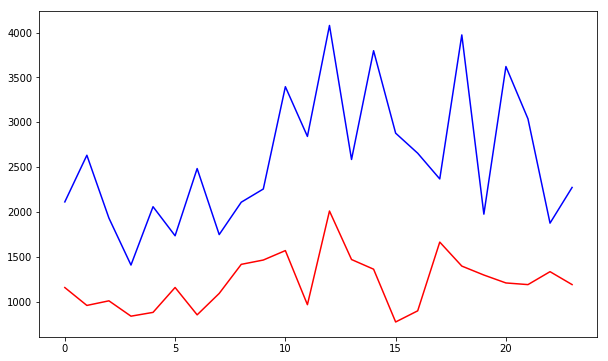

In [61]:
### Household demand curve for the considered day

hh_load_1 = pd.DataFrame((household_load_var[3][col]+1)*household_size[3])
day_hh_1 = pd.DataFrame(hh_load_1.values*household_load_day.values, columns=hh_load_1.columns, index=hh_load_1.index)
hh_load_2 = pd.DataFrame((household_load_var[4][col]+1)*household_size[4])
day_hh_2 = pd.DataFrame(hh_load_2.values*household_load_day.values, columns=hh_load_2.columns, index=hh_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_hh_1 ,'r')
plt.plot(day_hh_2,'b')
plt.show()


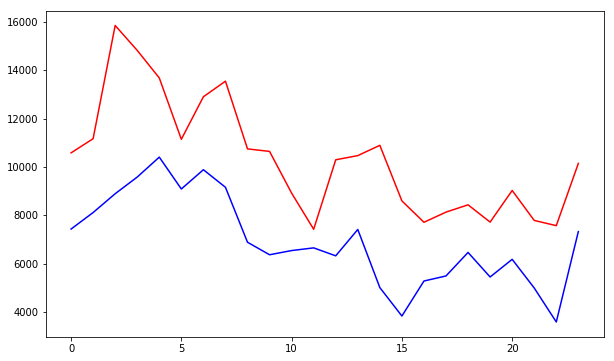

340

In [62]:
### Office demand curve for the considered day

off_load_1 = pd.DataFrame(office_load_v3[1][col])
day_oh_1 = pd.DataFrame(off_load_1.values*household_load_day.values, columns=off_load_1.columns, index=off_load_1.index)
off_load_2 = pd.DataFrame(office_load_v3[2][col])
day_oh_2 = pd.DataFrame(off_load_2.values*household_load_day.values, columns=off_load_2.columns, index=off_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_oh_1 ,'r')
plt.plot(day_oh_2,'b')
plt.show()
office_size[2]

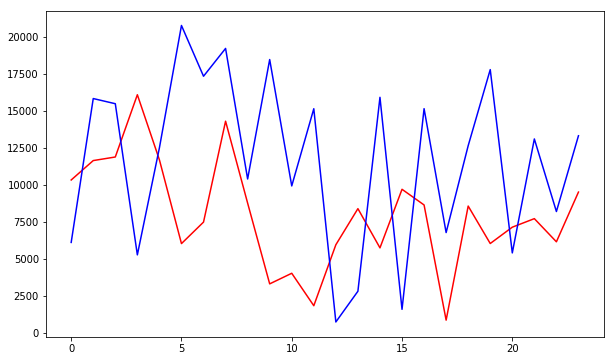

In [89]:
### School demand curve for the considered day

edu_load_1 = pd.DataFrame(education_load_v3[5][col])
day_eh_1 = pd.DataFrame(edu_load_1.values*household_load_day.values, columns=edu_load_1.columns, index=edu_load_1.index)
edu_load_2 = pd.DataFrame(education_load_v3[2][col])
day_eh_2 = pd.DataFrame(edu_load_2.values*household_load_day.values, columns=edu_load_2.columns, index=edu_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_eh_1 ,'r')
plt.plot(day_eh_2,'b')
plt.show()


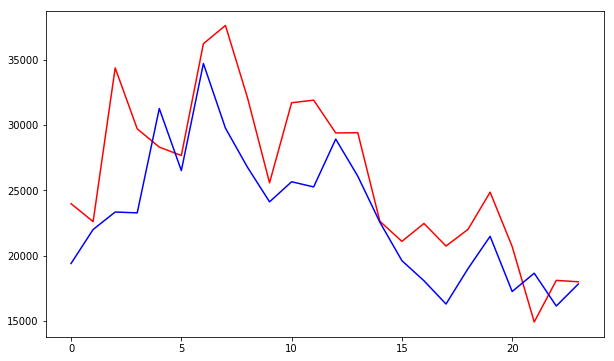

In [64]:
### Hospital demand curve for the considered day
hos_load_1 = pd.DataFrame(hospital_load_v3[1][col])
day_hosh_1 = pd.DataFrame(hos_load_1.values*household_load_day.values, columns=hos_load_1.columns, index=hos_load_1.index)
hos_load_2 = pd.DataFrame(hospital_load_v3[2][col])
day_hosh_2 = pd.DataFrame(hos_load_2.values*household_load_day.values, columns=hos_load_2.columns, index=edu_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_hosh_1 ,'r')
plt.plot(day_hosh_2,'b')
plt.show()

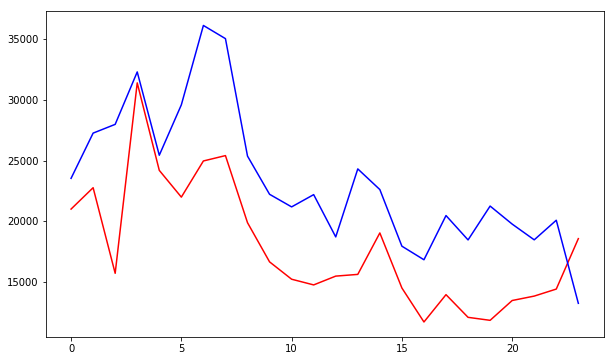

In [65]:
### Hotel demand curve for the considered day
hot_load_1 = pd.DataFrame(hotel_load_v3[1][col])
day_hoth_1 = pd.DataFrame(hot_load_1.values*household_load_day.values, columns=hot_load_1.columns, index=hot_load_1.index)
hot_load_2 = pd.DataFrame(hotel_load_v3[2][col])
day_hoth_2 = pd.DataFrame(hot_load_2.values*household_load_day.values, columns=hot_load_2.columns, index=hot_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_hoth_1 ,'r')
plt.plot(day_hoth_2,'b')
plt.show()

In [66]:
####################### Load Profils Generation END #############################
#################################################################################
### Give every spotload node a load profil

hh_v_hour = pd.DataFrame(hh_v_hour)
off_load_hour = pd.DataFrame(off_load_hour)
edu_load_hour = pd.DataFrame(edu_load_hour)
hos_load_hour = pd.DataFrame(hos_load_hour)
hot_load_hour = pd.DataFrame(hot_load_hour)

load_list = pd.concat([hh_v_hour, off_load_hour, hos_load_hour, hot_load_hour, edu_load_hour], ignore_index = True)
load_list = load_list.rename(columns={0:'demand_kW'})

load_list['demand_kW'] = load_list['demand_kW'].astype(float)
load_list = load_list['demand_kW'] * household_load_pm_hour['Current']
load_list = pd.DataFrame(load_list)

In [67]:
section_spotload_demand = section_spotload.merge(load_list, left_index=True, right_index=True)
section_spotload_demand

,index,SectionID,FromNodeID,ToNodeID,demand_kW
0,6,42783662-SPOTLOAD,42783662,42783662-SPOTLOAD,1581.481035
1,11,42787380-SPOTLOAD,42787380,42787380-SPOTLOAD,5721.286340
2,15,42769314-SPOTLOAD,42769314,42769314-SPOTLOAD,2391.072446
3,21,42777729-SPOTLOAD,42777729,42777729-SPOTLOAD,1531.108231
4,48,42783479-SPOTLOAD,42783479,42783479-SPOTLOAD,4253.589669
5,52,42785340-SPOTLOAD,42785340,42785340-SPOTLOAD,2342.100778
6,56,42793224-SPOTLOAD,42793224,42793224-SPOTLOAD,6997.605624
7,58,42767154-SPOTLOAD,42767154,42767154-SPOTLOAD,2678.926872
8,84,152492633-SPOTLOAD,152492633,152492633-SPOTLOAD,2751.179649
9,163,42937051-SPOTLOAD,42937051,42937051-SPOTLOAD,1044.084129


In [68]:
for _, load in section_spotload_demand.iterrows():
    bus_idx = pp.get_element_index(net, "bus", load.FromNodeID)
    phi = math.acos(95/100)
    pp.create_load(net, bus_idx, p_kw = load.demand_kW/1000, q_kvar = (math.tan(phi)*load.demand_kW)/1000 , const_z_percent=0, const_i_percent=0, 
                   name = "load "+ load.FromNodeID, scaling=1., in_service=True)

In [69]:
net.load

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,load 42783662,1824,1.581481,0.519808,0.0,0.0,NaN,1.0,True,None
1,load 42787380,1037,5.721286,1.880496,0.0,0.0,NaN,1.0,True,None
2,load 42769314,2229,2.391072,0.785908,0.0,0.0,NaN,1.0,True,None
3,load 42777729,893,1.531108,0.503251,0.0,0.0,NaN,1.0,True,None
4,load 42783479,1869,4.253590,1.398087,0.0,0.0,NaN,1.0,True,None
5,load 42785340,939,2.342101,0.769811,0.0,0.0,NaN,1.0,True,None
6,load 42793224,1207,6.997606,2.300002,0.0,0.0,NaN,1.0,True,None
7,load 42767154,2063,2.678927,0.880521,0.0,0.0,NaN,1.0,True,None
8,load 152492633,99,2.751180,0.904269,0.0,0.0,NaN,1.0,True,None
9,load 42937051,486,1.044084,0.343174,0.0,0.0,NaN,1.0,True,None


In [70]:
solar_data_file = os.path.join('network_data/Timeseries_46.464_6.843_CM__1kWp_crystSi_14_37deg_-5deg_2016_2016.csv')

data_solar = pd.read_csv(solar_data_file, skiprows=10, skipfooter=12, engine='python')
data_solar.set_index(pd.to_datetime(data_solar["Date"], format="%Y%m%d:%H%M")+ pd.Timedelta(minutes=5), inplace=True)
data_solar = data_solar.drop('Date', 1)

radiation = data_solar.loc[date_time].EPV / 1000
radiation

0.23838999999999999

In [71]:
## Photovoltaics

section_pv['FromNodeID'].drop_duplicates()

pv_gen = pd.read_csv('network_data/pv_generator.csv', sep=',', header=0, decimal=',')
pv_gen['DeviceNumber'] = pv_gen['DeviceNumber'].apply(lambda x: x.split('-')[0])
pv_gen[["ActiveGeneration", "PowerFactor"]] = pv_gen[["ActiveGeneration", "PowerFactor"]].astype(float)
pv_gen = pv_gen[pv_gen['LoadModelName'] == 'MOYENNE']
pv_gen['ProducedActGen'] = pv_gen['ActiveGeneration']* radiation
pv_gen = pv_gen.drop_duplicates().reset_index(drop=True)

pv_gen

,DeviceNumber,DeviceType,LoadModelName,ActiveGeneration,PowerFactor,ProducedActGen
0,42778481,45,MOYENNE,12.81238,100.0,3.054343
1,42816058,45,MOYENNE,10.98204,100.0,2.618009
2,42819953,45,MOYENNE,7.32136,100.0,1.745339
3,42819954,45,MOYENNE,7.32136,100.0,1.745339
4,78874605,45,MOYENNE,10.98204,100.0,2.618009
5,42783662,45,MOYENNE,5.49102,100.0,1.309004
6,42783436,45,MOYENNE,3.66068,100.0,0.872670
7,42762511,45,MOYENNE,5.49102,100.0,1.309004
8,42787380,45,MOYENNE,7.32136,100.0,1.745339
9,42819955,45,MOYENNE,7.32136,100.0,1.745339


In [72]:
### Photovoltaics production of considered day, only needed for nice pictures /curves

radiation_day = pd.DataFrame(data_solar.loc[date_start:date_end].EPV / 1000).reset_index(drop=True)
radiation_day = radiation_day['EPV'].astype(float)
ActGen_day = pd.DataFrame(pv_gen['ActiveGeneration'].astype(float)).reset_index(drop=True)

#pv_gen_day = ActGen_day['ActiveGeneration'].loc[1]
#ActGen_day.loc[1]
#pv_gen_day = [[0 for x in range(14)] for h in range(24)] # 14 pv systems and 24 hour
pv_gen_day = []

for i in range(14):
    pv_gen_day_v0 = []
    pv_gen_day_v0 =  radiation_day*ActGen_day['ActiveGeneration'].loc[i]
    pv_gen_day.append(pv_gen_day_v0)
pv_gen_day[13]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.006479
8     0.096020
9     0.142144
10    0.477902
11    0.617740
12    1.740068
13    0.818711
14    0.872670
15    0.521720
16    0.254381
17    0.110919
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: EPV, dtype: float64

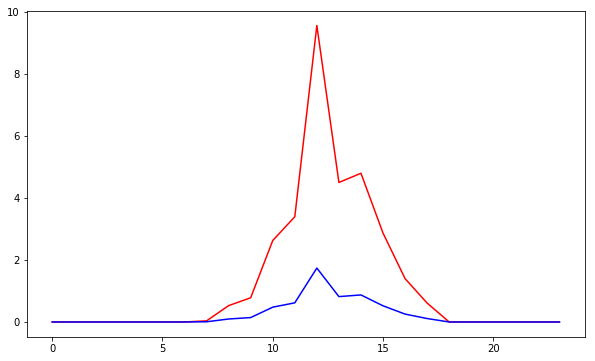

In [73]:
plt.figure(1, figsize=(10, 6))
plt.plot(pv_gen_day[11] ,'r')
plt.plot(pv_gen_day[13],'b')
plt.show()

In [74]:
# creating the pv table

for _,row in pv_gen.iterrows():
    phi = math.acos(row.PowerFactor/100)
    pp.create_sgen(net, pp.get_element_index(net, "bus", row.DeviceNumber), p_kw=-row.ProducedActGen,
                   q_kvar=(-1)*math.tan(phi)*row.ProducedActGen, type='PV', name=row.DeviceNumber)

# show static generator table
#pv_gen
net.sgen

,name,bus,p_kw,q_kvar,sn_kva,scaling,in_service,type
0,42778481,1903,-3.054343,-0.0,NaN,1.0,True,PV
1,42816058,1808,-2.618009,-0.0,NaN,1.0,True,PV
2,42819953,878,-1.745339,-0.0,NaN,1.0,True,PV
3,42819954,773,-1.745339,-0.0,NaN,1.0,True,PV
4,78874605,838,-2.618009,-0.0,NaN,1.0,True,PV
5,42783662,1824,-1.309004,-0.0,NaN,1.0,True,PV
6,42783436,1358,-0.872670,-0.0,NaN,1.0,True,PV
7,42762511,781,-1.309004,-0.0,NaN,1.0,True,PV
8,42787380,1037,-1.745339,-0.0,NaN,1.0,True,PV
9,42819955,1146,-1.745339,-0.0,NaN,1.0,True,PV


In [75]:
pp.create_ext_grid(net, pp.get_element_index(net, "bus", '42879302'), vm_pu=1.03, va_degree=0, name='External grid',
                   s_sc_max_mva=10000, rx_max=0.1, rx_min=0.1) 


0

In [76]:
net.ext_grid # show external grid table

,name,bus,vm_pu,va_degree,in_service,s_sc_max_mva,rx_min,rx_max
0,External grid,2,1.03,0.0,True,10000.0,0.1,0.1


In [77]:
pp.runpp(net, max_iteration=1000)

In [78]:
net.res_ext_grid

,p_kw,q_kvar
0,-3864.192371,-1325.718895


In [79]:
net.res_load

,p_kw,q_kvar
0,1.581481,0.519808
1,5.721286,1.880496
2,2.391072,0.785908
3,1.531108,0.503251
4,4.253590,1.398087
5,2.342101,0.769811
6,6.997606,2.300002
7,2.678927,0.880521
8,2.751180,0.904269
9,1.044084,0.343174


In [80]:
net.res_sgen

,p_kw,q_kvar
0,-3.054343,-0.0
1,-2.618009,-0.0
2,-1.745339,-0.0
3,-1.745339,-0.0
4,-2.618009,-0.0
5,-1.309004,-0.0
6,-0.872670,-0.0
7,-1.309004,-0.0
8,-1.745339,-0.0
9,-1.745339,-0.0


In [81]:
net.res_bus

,vm_pu,va_degree,p_kw,q_kvar
0,1.029453,-0.007830,0.000000,0.000000
1,1.029453,-0.007830,0.000000,0.000000
2,1.030000,0.000000,-3864.192371,-1325.718895
3,1.029999,-0.000037,0.000000,0.000000
4,1.029416,-0.008529,0.000000,0.000000
5,1.029453,-0.007830,0.000000,0.000000
6,1.029453,-0.007830,0.000000,0.000000
7,1.029453,-0.007830,0.000000,0.000000
8,1.029265,-0.010040,0.000000,0.000000
9,1.029386,-0.008803,0.000000,0.000000


In [82]:
net.res_line

,p_from_kw,q_from_kvar,p_to_kw,q_to_kvar,pl_kw,ql_kvar,i_from_ka,i_to_ka,i_ka,loading_percent
0,-3.975947e+00,-1.880496e+00,3.977027e+00,1.880562e+00,1.079610e-03,6.626052e-05,5.921438e-03,5.921438e-03,5.921438e-03,5.383126e+00
1,-9.521359e+00,-4.699789e+00,9.524378e+00,4.700396e+00,3.018855e-03,6.070013e-04,1.429615e-02,1.429615e-02,1.429615e-02,9.530768e+00
2,1.350744e+01,6.582172e+00,-1.350141e+01,-6.580958e+00,6.037228e-03,1.213913e-03,2.021700e-02,2.021700e-02,2.021700e-02,1.347800e+01
3,-4.429142e+00,1.204024e-01,4.430002e+00,-1.202295e-01,8.600666e-04,1.729239e-04,5.965188e-03,5.965188e-03,5.965188e-03,3.976792e+00
4,4.430146e+00,-1.201770e-01,-4.430002e+00,1.202295e-01,1.433444e-04,5.251963e-05,5.965188e-03,5.965188e-03,5.965188e-03,2.339289e+00
5,-1.241869e-10,-2.538794e-07,1.239219e-10,6.268483e-08,-2.649971e-13,-1.911946e-07,3.407328e-10,8.412977e-11,3.407328e-10,1.068128e-07
6,1.159600e-10,5.224059e-08,-1.143671e-10,-6.268458e-08,1.592954e-12,-1.044399e-08,7.011252e-11,8.412942e-11,8.412942e-11,2.637286e-08
7,-4.498910e+01,-1.759124e-01,4.508191e+01,2.028007e-01,9.280510e-02,2.688835e-02,6.094005e-02,6.094005e-02,6.094005e-02,2.168685e+01
8,-1.370056e+01,-9.932151e+00,1.370160e+01,9.932534e+00,1.044831e-03,3.828239e-04,2.277570e-02,2.277570e-02,2.277570e-02,8.931648e+00
9,1.372006e+01,9.939627e+00,-1.370160e+01,-9.932534e+00,1.845869e-02,7.093123e-03,2.277570e-02,2.277570e-02,2.277570e-02,1.035259e+01


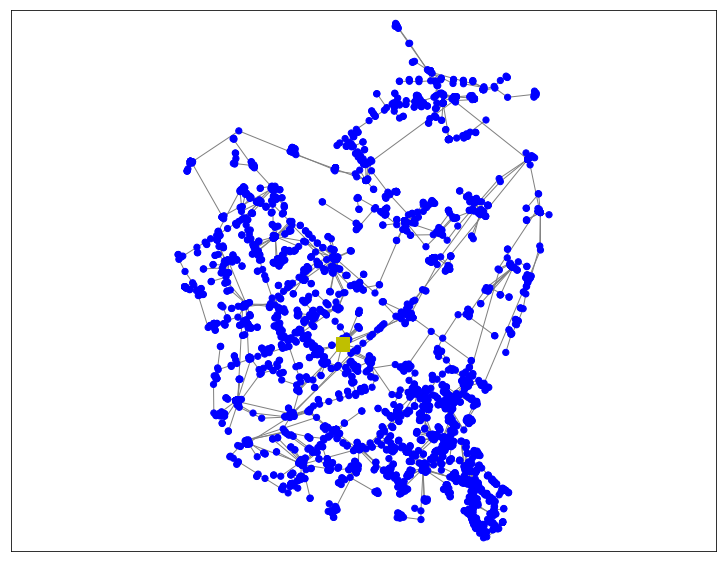

In [83]:
from pandapower.plotting.plotly import simple_plotly

plot.simple_plot(net, bus_size=0.7, respect_switches = True) # , on_map=True, projection='epsg:'


/home/bigboss/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


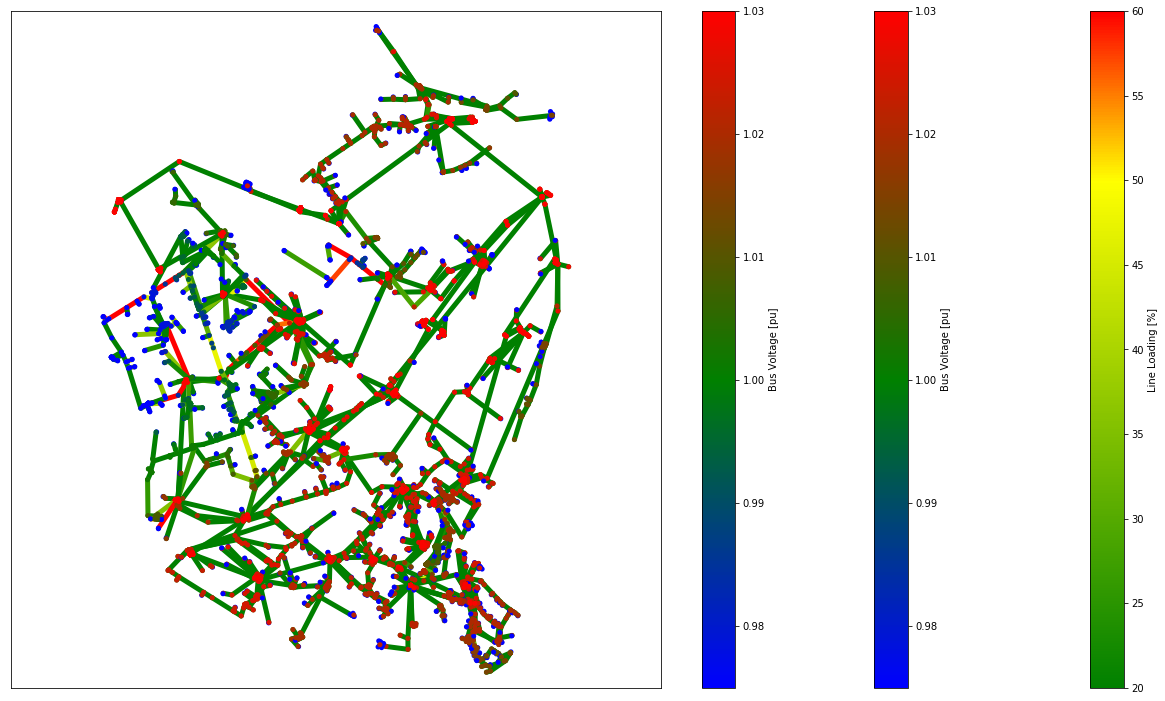

In [84]:
cmap_list=[(20, "green"), (50, "yellow"), (60, "red")]
cmap, norm = plot.cmap_continous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=5)

cmap_list=[(0.975, "blue"), (1.0, "green"), (1.03, "red")]
cmap, norm = plot.cmap_continous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=5, zorder=2, cmap=cmap, norm=norm)

loadc = plot.create_bus_collection(net, net.load.index, size=5, zorder=2, cmap=cmap, norm=norm)
pvc = plot.create_bus_collection(net, net.sgen.index, size=5, zorder=1, cmap=cmap, norm=norm)

plot.draw_collections([lc, bc, loadc], figsize=(18,10))


In [85]:
from pandapower.plotting.plotly import pf_res_plotly
pf_res_plotly(net, cmap=cmap, use_line_geodata=net.line_geodata, on_map=False, projection=None, map_style='basic',
              figsize=1, aspectratio='auto', line_width=2, bus_size=10)


NameError: name 'Marker' is not defined

In [ ]:
vlevel_plotly(net)